### Simulating a mortgage portfolio (II)

Mortgages typically have a lineair interest rate model - where the monthly prepayment is fixed, or use an annualized schema - in which interest plus prepayment makes a fixed amount per month. To start, we model all mortgages with the lineair interest rate model.

See also: https://riskatwork.nl/wp-content/uploads/2019/11/RAW-MortgagePrepayments.pdf

Customers normally have the option to re-pay the mortgage earlier then the maturity / repricing data.  In general a bank loan may not be held until maturity because:
* Customers repay the loan early (as a percentage of the loan, or fully when moving)
* Customers can default on the loan - forcing the bank to write off the loan

Growth and new business 
Customers can choose the fixed interest period they select. Their choice will be influenced by market expectations, and the rates offered by the bank. 

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from datetime import timedelta
from dateutil.parser import parse

from src.models.bank_model import Bankmodel
from src.data.zerocurve import Zerocurve
from src.data.interest import Interest
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Create data objects
zerocurve = Zerocurve()
interest = Interest()

In [6]:
# Get zero curve historic rates
zerocurve.read_data()
# Get mortgage historic rates
interest.read_data()

2023-03-18 12:40:24.559 | INFO     | src.data.dataset:read_data:26 - reading zerocurve data from ESW.
c:\Users\M\miniconda3\envs\rlalm\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
2023-03-18 12:40:25.783 | INFO     | src.data.dataset:read_data:26 - reading interest data from ESW.


<Response [200]>

In [7]:
zerocurve.save_data()
interest.save_data()

2023-03-18 12:40:27.358 | INFO     | src.data.dataset:save_data:55 - saving zerocurve data to file.
2023-03-18 12:40:27.717 | INFO     | src.data.dataset:save_data:55 - saving interest data to file.


In [8]:
# Load data from csv file - not directly from ECB
zerocurve.load_data()
interest.load_data()

2023-03-18 12:40:29.339 | INFO     | src.data.dataset:load_data:45 - loading zerocurve data from file.
c:\Users\M\miniconda3\envs\rlalm\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
2023-03-18 12:40:29.562 | INFO     | src.data.dataset:load_data:45 - loading interest data from file.


In [9]:
# pos_date = parse('28-02-2023')
bankmodel = Bankmodel(pos_date = zerocurve.df.index[-1])
bankmodel.generate_mortgage_contracts(n = 300, df_i = interest.df)
bankmodel.df_mortgages.head()

2023-03-18 12:40:30.898 | INFO     | src.models.bank_model:generate_mortgage_contracts:111 - Added 300 mortgages to our portfolio.
2023-03-18 12:40:36.521 | INFO     | src.models.bank_model:generate_mortgage_contracts:115 - Added 52668 cashflows to our model.


,category,fixed_period,years,start_date,principal,period,interest,contract
0,3,>10 years,20,2014-06-23,200000,2014-06-01,4.48,0
1,1,1>5 years,5,2018-10-18,200000,2018-10-01,2.05,1
2,2,5>10 years,10,2019-11-07,200000,2019-11-01,2.37,2
3,2,5>10 years,10,2015-03-19,200000,2015-03-01,3.05,3
4,0,<= 1 year,1,2023-01-16,200000,2023-01-01,3.79,4


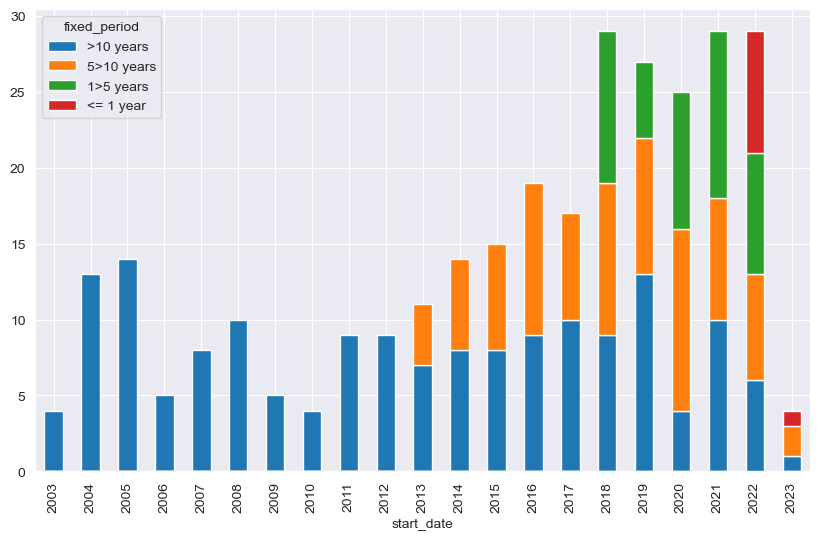

In [10]:
bankmodel.plot_contracts();

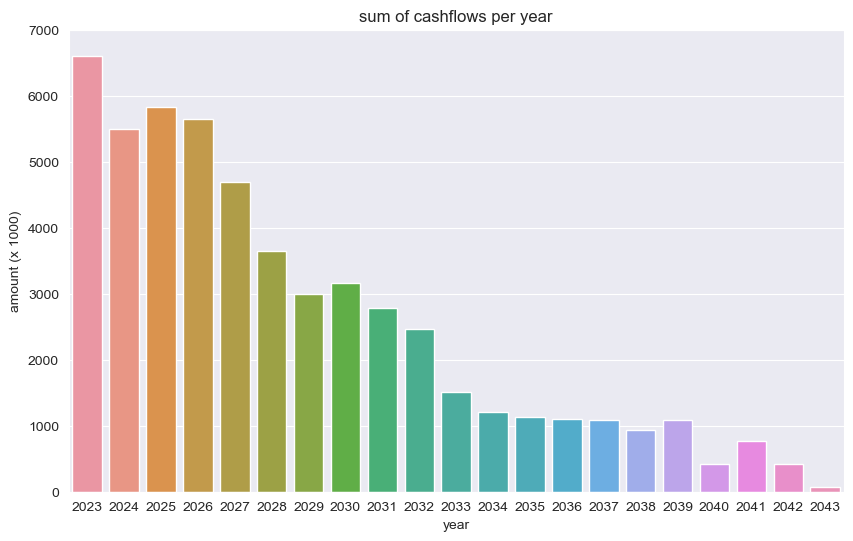

In [11]:
bankmodel.plot_cashflows()

### npv calculation

$$NPV = {{Cashflow} \over (1+i)^T}.$$
$$DF_0^T = [1+R_{zc}]^{-T})$$
where:
- $DF_0^T$  = a discount factor with maturity T
- $R_{zc}$ = A zero coupon interest rate
- $T$ = Maturity of the zero rate, in years (calculated as days/365)

In [13]:
bankmodel.calculate_npv(zerocurve)

45875890.46000001

In [14]:
bankmodel.step()
zerocurve.step()
bankmodel.calculate_npv(zerocurve)



2023-03-18 12:41:27.784 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-03-01 00:00:00.


45905535.82

2023-03-18 12:45:02.411 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-03-01 00:00:00.
2023-03-18 12:45:02.453 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-03-02 00:00:00.
2023-03-18 12:45:02.491 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-03-03 00:00:00.
2023-03-18 12:45:02.526 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-03-06 00:00:00.
2023-03-18 12:45:02.575 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-03-07 00:00:00.
2023-03-18 12:45:02.611 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-03-08 00:00:00.
2023-03-18 12:45:02.645 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-03-09 00:00:00.
2023-03-18 12:45:02.683 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-03-10 00:00:00.
2023-03-18 12:45:02.723 | DEBUG    | src.data.zerocurve:step:124 - Stepping in zerocurve 2023-03-13 00:00:00.
2023-03-18

<AxesSubplot:>

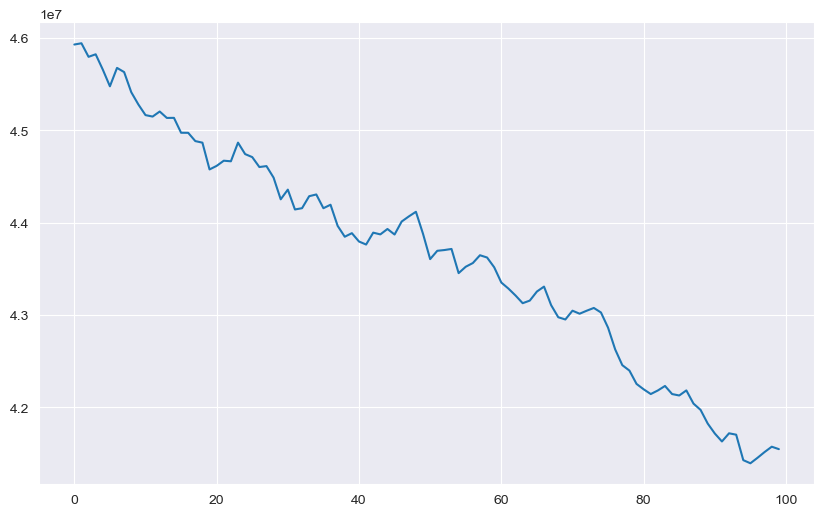

In [20]:
# run an episode of 100 steps

returns = []
for i in range(100):
    bankmodel.step()
    zerocurve.step()
    returns.append(bankmodel.calculate_npv(zerocurve))

sns.lineplot(returns)

In [17]:
bankmodel.reset()
zerocurve.reset()

c:\Users\M\miniconda3\envs\rlalm\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [19]:
bankmodel.calculate_npv(zerocurve)

45875890.46000001

Non Maturity Deposits

#### Core vs Non Core balances
For saving deposits a cap on the average maturity of the core deposits is set at 4.5 years. 
In general 70% - 90% of the deposits can be classied as core capital. (See guidelines BCBS)